In [35]:
using_colab = True

In [36]:
!git clone https://github.com/uni-medical/SAM-Med2D.git SAM_Med2D
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    # !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    # !mkdir images
    # !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

else:
    # not sure for this part! Please check!
    !pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 -f https://download.pytorch.org/whl/torch_stable.html
    !pip install opencv-python matplotlib
    !pip install 'git+https://github.com/facebookresearch/segment-anything.git'

PyTorch version: 2.1.1+cu118
Torchvision version: 0.16.1+cu118
CUDA is available: True


fatal: destination path 'SAM_Med2D' already exists and is not an empty directory.


In [37]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import sys

In [38]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [39]:
image = cv2.imread('data_demo/images/78_left__cotton_wool_spots.jpg')
image.shape

(896, 896, 3)

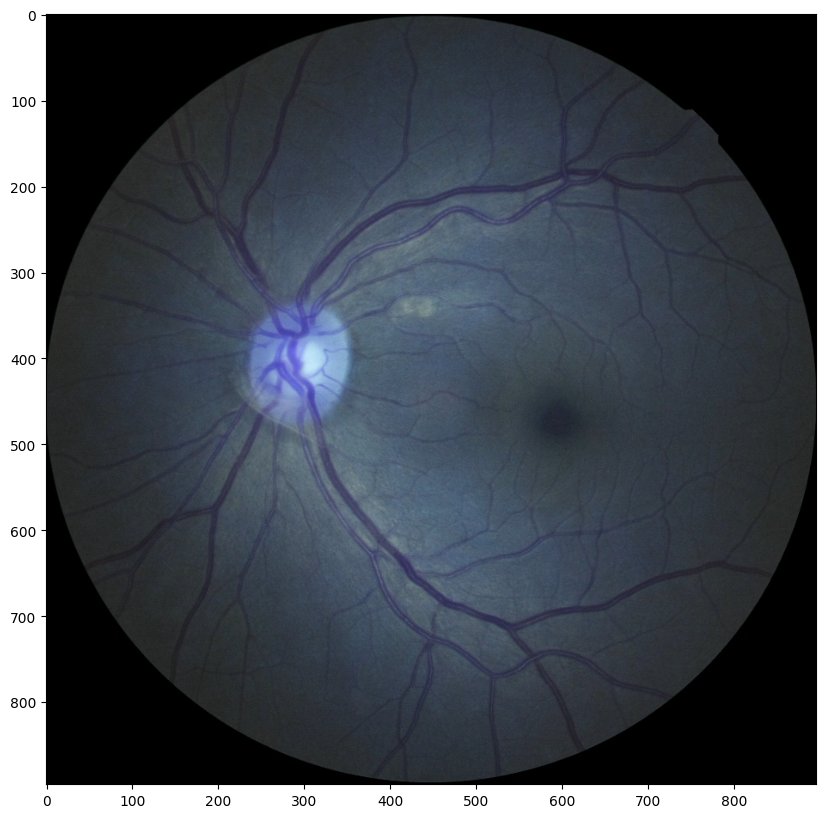

In [40]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()

In [41]:
from segment_anything import sam_model_registry
from segment_anything.predictor_sammed import SammedPredictor
from argparse import Namespace
args = Namespace()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args.image_size = 256
args.encoder_adapter = True
args.sam_checkpoint = "H:/workspace/Nabeel/SAM-Med2D-main/pretrain_model/epoch45_sam.pth"
model = sam_model_registry["vit_b"](args).to(device)
predictor = SammedPredictor(model)

True
*******load H:/workspace/Nabeel/SAM-Med2D-main/pretrain_model/epoch45_sam.pth


In [42]:
predictor.set_image(image)

In [43]:
ori_h, ori_w, _ = image.shape
input_point = np.array([[310, 400]])
input_label = np.array([1])

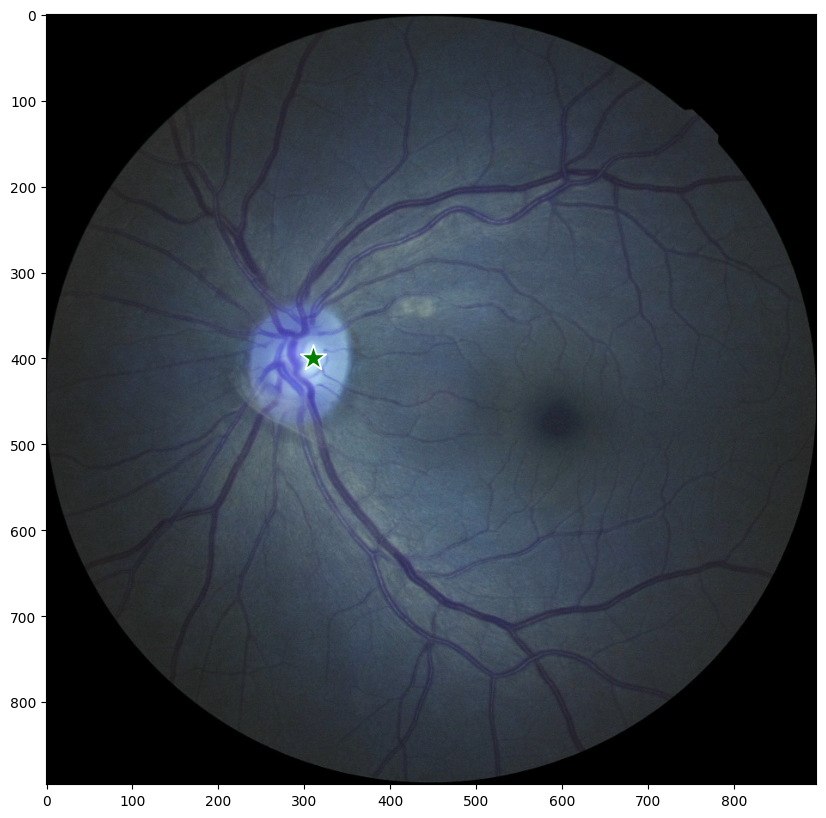

In [44]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [45]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
masks.shape 

(1, 896, 896)

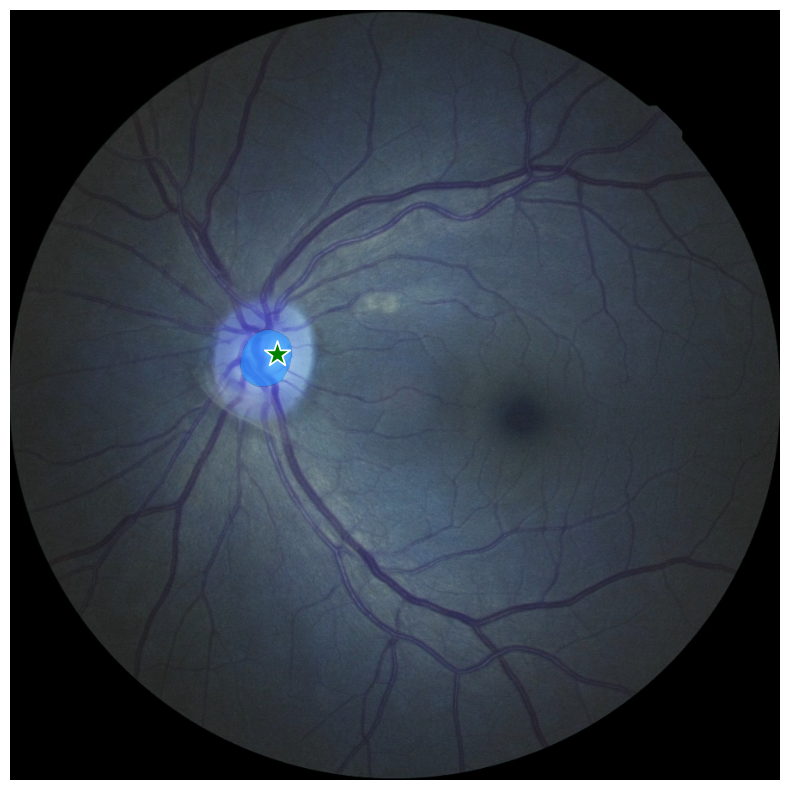

In [46]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

In [52]:
input_point1 = np.array([[320, 410]])
input_label1 = np.array([0])
input_points = np.concatenate((input_point, input_point1))
input_labels = np.concatenate((input_label, input_label1))
mask_inputs = torch.sigmoid(torch.as_tensor(logits, dtype=torch.float, device=device))

In [53]:
masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    mask_input = mask_inputs,
    multimask_output=True,
)
masks.shape

(1, 896, 896)

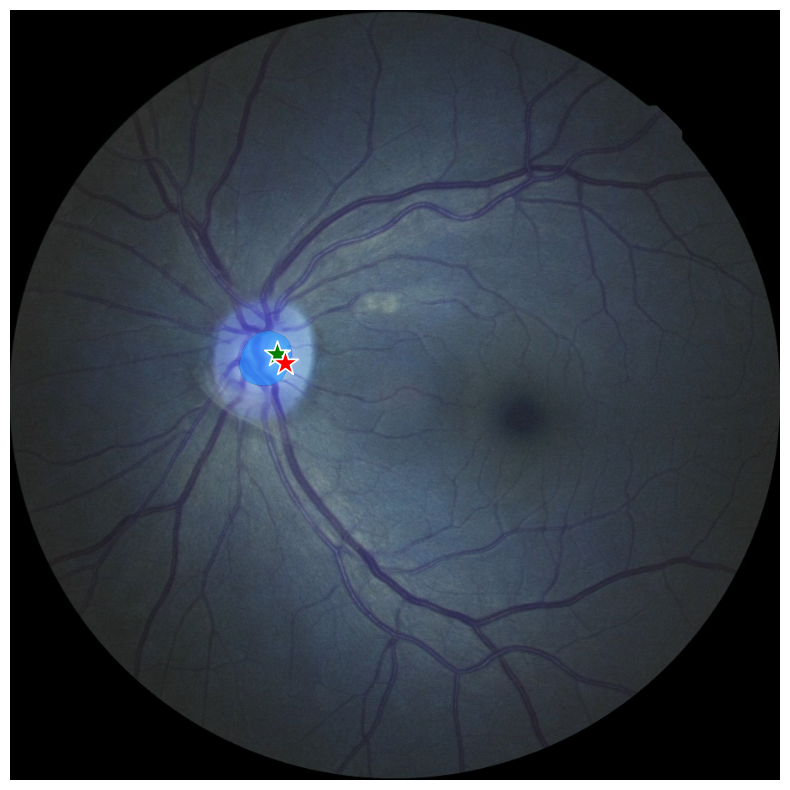

In [54]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_points, input_labels, plt.gca())
plt.axis('off')
plt.show()

In [52]:
input_point1 = np.array([[320, 410]])
input_label1 = np.array([0])
input_points = np.concatenate((input_point, input_point1))
input_labels = np.concatenate((input_label, input_label1))
mask_inputs = torch.sigmoid(torch.as_tensor(logits, dtype=torch.float, device=device))

In [50]:
#image = cv2.imread('data_demo/images/99_right__microaneurysm.jpg')
#input_box = np.array([780,300, 850,450])

In [51]:
#masks, _, _ = predictor.predict(
 #   point_coords=None,
 #   point_labels=None,
  #  box=input_box,
  #  multimask_output=True,
#)

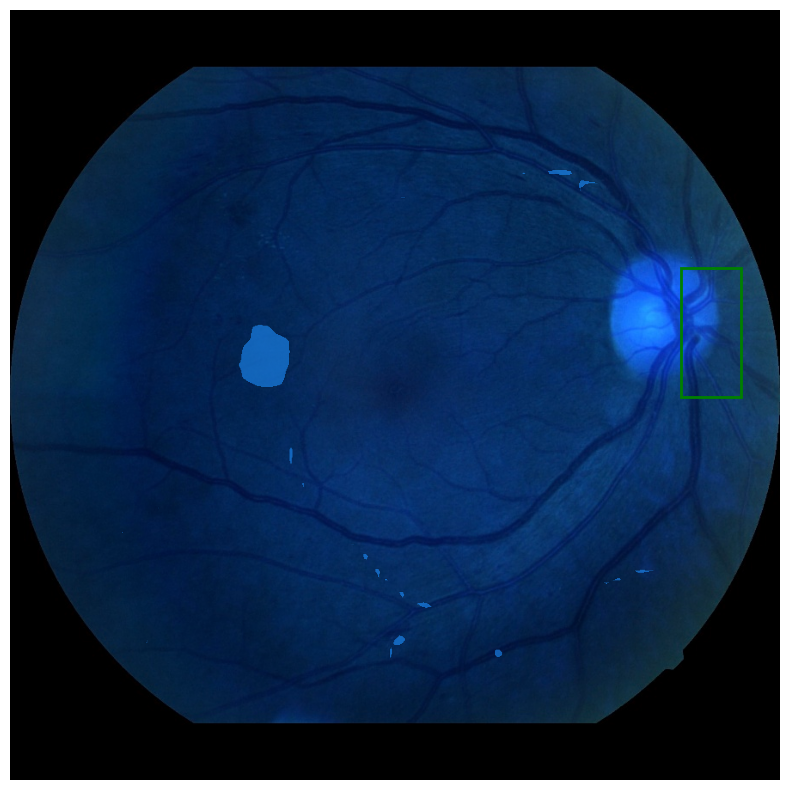

In [30]:
#plt.figure(figsize=(10, 10))
#plt.imshow(image)
#show_mask(masks[0], plt.gca())
#show_box(input_box, plt.gca())
#plt.axis('off')
#plt.show()

In [19]:
#input_boxes = torch.tensor([[310,200,250,150],[420,230,330,150]], device=predictor.device)  

In [20]:
#transformed_boxes = predictor.apply_boxes_torch(input_boxes, image.shape[:2], (args.image_size, args.image_size))
#masks, _, _ = predictor.predict_torch(
#    point_coords=None,
#    point_labels=None,
#    boxes=transformed_boxes,
#    multimask_output=True,
#)
#print(transformed_boxes.shape)
#print(masks.shape)  

torch.Size([2, 4])
torch.Size([2, 1, 896, 896])


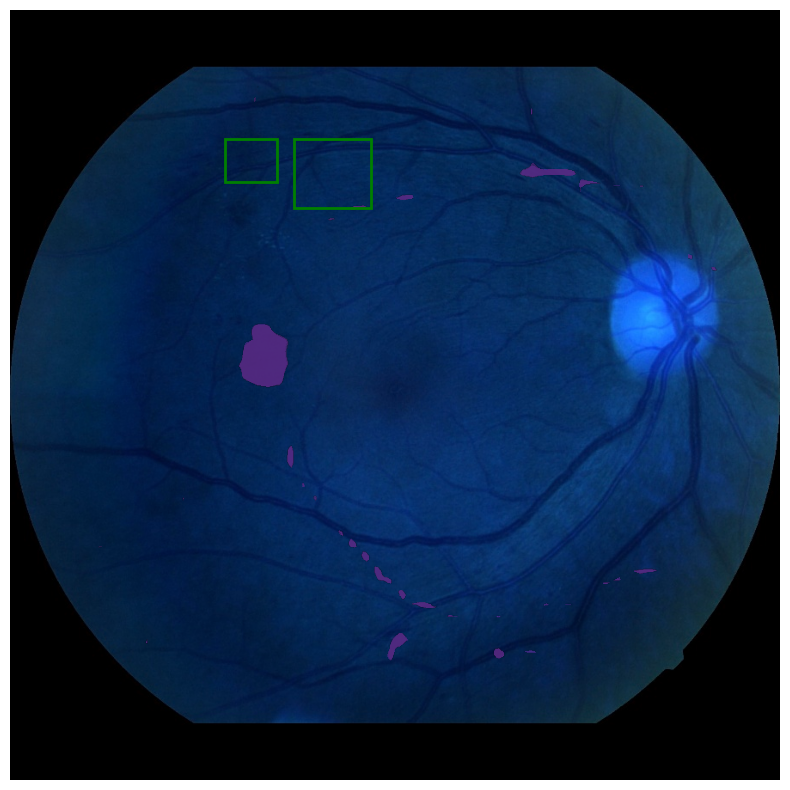

In [21]:
#plt.figure(figsize=(10, 10))
#plt.imshow(image)
#for mask in masks:
#    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
#for box in input_boxes:
#    show_box(box.cpu().numpy(), plt.gca())
#plt.axis('off')
#plt.show()